In [1]:
# imports
from ema_workbench.analysis import parcoords
import pandas as pd
import numpy as np
from ema_workbench import load_results
import seaborn as sns
import os
from model.enums import BeliefUpdate
from dmdu.utils_dmdu import get_lever_names, get_outcome_names
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
from dmdu.exploration.utils import parcoords_levers, parcoords_outcomes

sns.set(rc={'figure.figsize': (7, 5)})

# Assign each unique model a color
model_names = [x.name for x in list(BeliefUpdate)]
model_colors = {}
# colors = ["blue", "green", "red"]
# colors = ["darkorange", "dodgerblue", "forestgreen"]
colors = ["darkorange", "blue", "limegreen"]
# colors = [
#     (255,69,0,1),  # orange red
#     (0,0,205,1),  # medium blue
#     (50,205,50,1)  # lime green
# ]

for _, (model, color) in enumerate(zip(model_names, colors)):
    # w/ color palette: zip(model_names, sns.color_palette("colorblind"))
    model_colors[model] = color


# Overall Plan:
1. avg over replications
2. non-dominated sort -> Pareto-optimal policies
3. parallel axis plots of levers & outcomes (to inspect Pareto-optimal policies)


### 1. Loading the data (results), avg over replications, save into .csv
(can just avg bc replications to make sure that sensitivity to stochasticity is not an issue wrt reproducibility)

In [6]:
# Params  # TODO: make a function 'load_my_csv(nfe, bufn, filename, seed=None)' make it also remove the "Unnamed: 0" col
n_repl = 30
# bufns = list(BeliefUpdate)  # [BeliefUpdate.DEFFUANT]  # -> BeliefUpdate.list
bufns = [BeliefUpdate.SIT]  # TODO: use above line instead
for bufn in bufns:

    # Loading the results
    path = os.path.join(
        os.getcwd(),
        "data",
        "reevaluation",
        f"results_{bufn.name}",
    )
    experiments, outcomes = load_results(path)

    # Experiments: Rescale lever values (*10 -> (0-10 -> 0-100, 0-5 -> 0-50))
    lever_names = get_lever_names()
    for col_name in experiments.columns:
        if col_name in lever_names:
            experiments[col_name] *= 10

    # Outcomes: Avg over replications (for each scenario)
    # TODO: for each scenario: get subset for one scenario, only then avg as below

    # If scenario & policy are the same (i.e., if same values for whole exp -> unique rows) (if remove

    # --------------\begin{Quick test whether saved properly}--------------
    # print(outcomes.keys())
    # print(experiments.head(35))
    # for k,v in outcomes.items():
    #     print(f"{k} \n {v}")
    # --------------\end{Quick test whether saved properly}--------------

    # for
    #     avgs_outcomes = {}
    #     # for metric in outcomes.keys():  # attempt
    #     for metric in get_outcome_names():
    #         avgs = np.mean(outcomes[metric], axis=1)
    #         avgs_outcomes[metric] = avgs
    #     print(f"outcomes: {avgs_outcomes.keys()}")
    #
    #     # Save into .csv  (dict -> df -> .csv)
    #     avgs_outcomes = pd.DataFrame(avgs_outcomes)
    #
    #     # # Outcomes: Remove 'Unnamed: 0' columns attempt
    #     # avgs_outcomes = avgs_outcomes[get_outcome_names()]



    # path = os.path.join(
    #     os.getcwd(),
    #     "data",
    #     "reevaluation",
    #     f"outcomes_{bufn.name}.csv"
    # )
    # # avgs_outcomes.to_csv(path)
    # outcomes_df = pd.DataFrame.from_dict(outcomes)  # bc no avgs, not yet df
    # outcomes_df.to_csv(path)  # bc no avgs, not yet df
    #
    # path = os.path.join(
    #     os.getcwd(),
    #     "data",
    #     "reevaluation",
    #     f"experiments_{bufn.name}.csv"
    # )
    # experiments.to_csv(path)


   belief_metric_threshold  n_edges  ratio_normal_user  mean_normal_user  \
0                       75        3           0.981800                 2   
1                       80        2           0.994454                 0   
2                       75        3           0.981800                 2   
3                       80        2           0.994454                 0   
4                       75        3           0.981800                 2   
5                       80        2           0.994454                 0   
6                       75        3           0.981800                 2   
7                       80        2           0.994454                 0   
8                       75        3           0.981800                 2   
9                       80        2           0.994454                 0   

   mean_disinformer  high_media_lit  deffuant_mu  sampling_p_update  \
0                10        0.297007     0.028081           0.017314   
1                 8  

### 2. non-dominated sort -> Pareto-optimal policies (& their outcomes)
(via terminal, using the pareto.py script)

w/ epsilon values:
- 2     –– n_agents_above_belief_threshold (maximize)
- 2     –– polarization_variance
- 40    –– engagement (maximize)
- 0.02  –– free_speech_constraint
- 1.0   –– avg_user_effort


### 3. parallel axis plots of levers & outcomes
(to inspect Pareto-optimal policies)


#### a) subset experiments (all 26k policies -> only pareto-optimal policies


In [3]:
# subset experiments (all 26k policies -> only pareto-optimal policies

bufns = list(BeliefUpdate)

for bufn in bufns:
    # load data (all policies)
    exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_{bufn.name}.csv")
    experiments = pd.read_csv(exp_path)

    # get idx that should be kept
    out_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"outcomes_{bufn.name}.csv")
    outcomes = pd.read_csv(out_path)
    column_headers = outcomes.columns
    idx_header = column_headers[0]
    pareto_idx = [x for x in outcomes[idx_header]]

    # subset data + save it (to .csv in output folder)
    subset_exp = experiments[experiments[idx_header].isin(pareto_idx)]
    filename = f"experiments_{bufn.name}.csv"
    path = os.path.join(os.getcwd(), "data", "paretosort", "output", filename)
    subset_exp.to_csv(path)





#### b) Load data files

In [4]:
# Load data files
experiments_dict = {}
outcomes_dict = {}
bufns = list(BeliefUpdate)  # [BeliefUpdate.DEFFUANT]  # -> BeliefUpdate.list

for bufn in bufns:
    # define paths
    exp_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"experiments_{bufn.name}.csv")
    out_path = os.path.join(os.getcwd(), "data", "paretosort", "output", f"outcomes_{bufn.name}.csv")
    # load data
    experiments = pd.read_csv(exp_path)
    outcomes = pd.read_csv(out_path)
    outcomes = outcomes[get_outcome_names()]  # without 'Unnamed: 0'

    # save data
    experiments_dict[bufn.name] = experiments
    outcomes_dict[bufn.name] = outcomes


#### c) Create parallel axis plots

##### Policies (i.e., Levers)

In [5]:
# # Policies (i.e., Levers)
#
# def parcoords_levers(exp_dict, bufn, model_colors=None):
#     """Plots a parallel axis plot for the passed belief update function (bufn)"""
#
#     # Get limits
#     exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_{bufn.name}.csv")
#     all_exp = pd.read_csv(exp_path)
#     only_levers = all_exp[get_lever_names()]
#     exp_limits = parcoords.get_limits(only_levers)
#
#     # Parallel axis plot
#     axes = parcoords.ParallelAxes(exp_limits)
#     data = exp_dict[bufn.name][get_lever_names()]
#     if model_colors:
#         color = model_colors[bufn.name]
#         axes.plot(data, color=color)
#     else:
#         axes.plot(data)



##### DEFFUANT

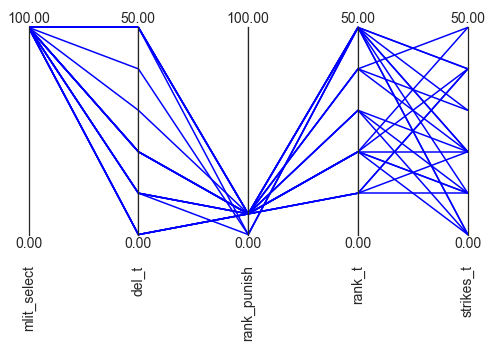

In [6]:
bufn = BeliefUpdate.DEFFUANT
parcoords_levers(experiments_dict, bufn, model_colors)

##### SAMPLE

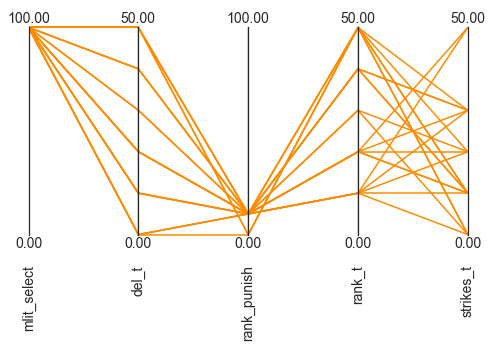

In [7]:
bufn = BeliefUpdate.SAMPLE
parcoords_levers(experiments_dict, bufn, model_colors)

##### SIT

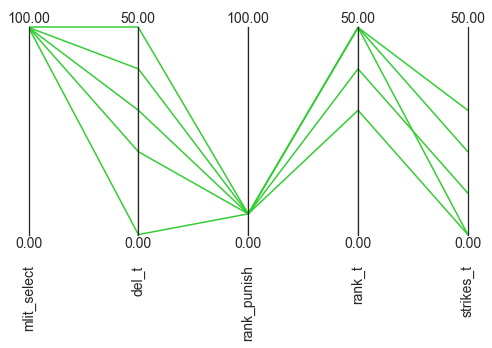

In [8]:
bufn = BeliefUpdate.SIT
parcoords_levers(experiments_dict, bufn, model_colors)

##### Combined
(not easy to see. bc Few possible values -> many overlaps)
# TODO: Would be good to have e.g., densitiy visible over range of lever dimension

In [9]:
concat_exp = pd.concat(experiments_dict.values())

# Get limits from input (-> not only Pareto-optimal policies, but all)
exp_path = os.path.join(os.getcwd(), "data", "paretosort", "input", f"experiments_DEFFUANT.csv")
# doesn't matter which bufn loaded above, all evaluated the same policies
all_exp = pd.read_csv(exp_path)
only_levers = all_exp[get_lever_names()]
exp_limits = parcoords.get_limits(only_levers)

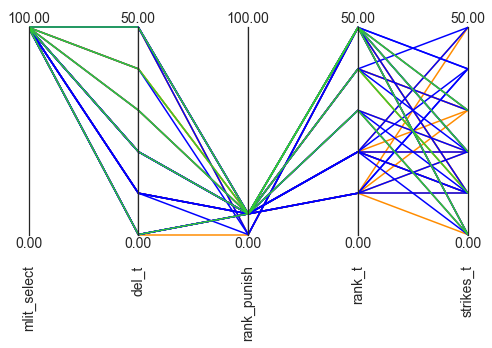

In [10]:
axes = parcoords.ParallelAxes(exp_limits)

for model_name, data in experiments_dict.items():
    color = model_colors[model_name]

    # subset data
    lever_data = data[get_lever_names()]
    axes.plot(lever_data, color=color)


##### Performance (i.e., Outcomes)

In [11]:
# Find limits over all outcomes



In [12]:
# def parcoords_outcomes(out_dict, bufn, model_colors=None):
#
#     # Get limits
#     concat_out = pd.concat(out_dict.values())
#     out_limits = parcoords.get_limits(concat_out)
#
#     axes = parcoords.ParallelAxes(out_limits)
#
#     minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
#     for metric in minimize:
#         axes.invert_axis(metric)
#
#     if model_colors:
#         color = model_colors[bufn.name]
#         axes.plot(data, color=color)
#     else:
#         axes.plot(data)




In [13]:
# Outcome plots need to be a bit bigger
sns.set(rc={'figure.figsize': (7, 7)})

##### DEFFUANT

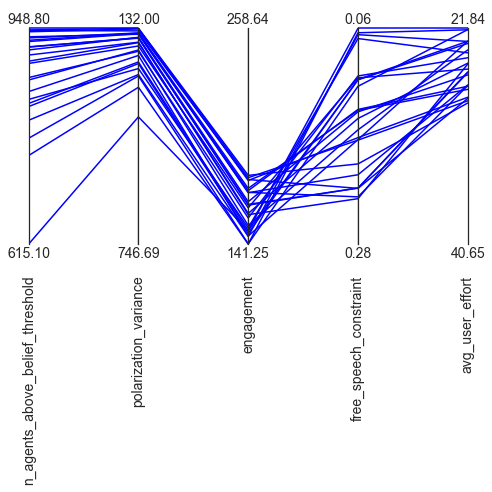

In [14]:
parcoords_outcomes(outcomes_dict, BeliefUpdate.DEFFUANT, model_colors)

##### SAMPLE

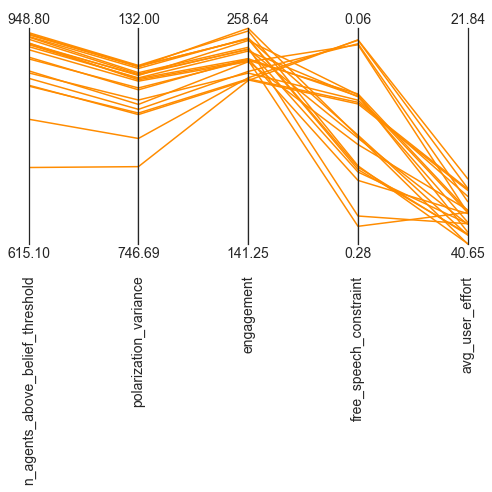

In [15]:
bufn = BeliefUpdate.SAMPLE
parcoords_outcomes(outcomes_dict, bufn, model_colors)

##### SIT

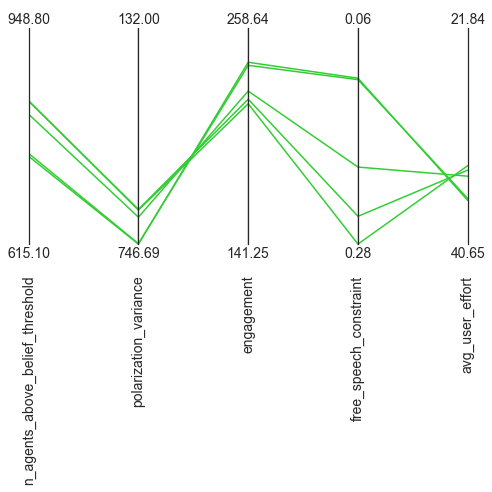

In [16]:
bufn = BeliefUpdate.SIT
parcoords_outcomes(outcomes_dict, bufn, model_colors)

##### Combined


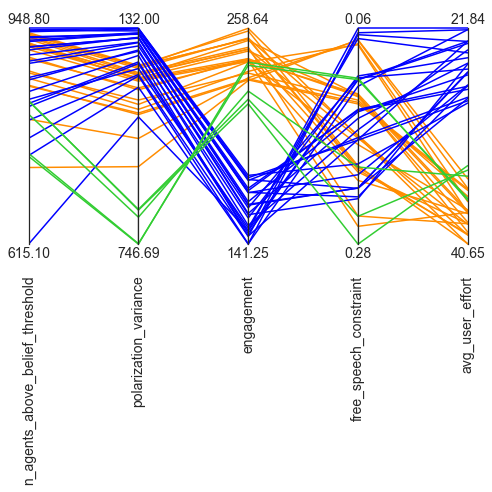

In [17]:

# Get limits
concat_out = pd.concat(outcomes_dict.values())
out_limits = parcoords.get_limits(concat_out)

axes = parcoords.ParallelAxes(out_limits)

minimize = ['polarization_variance', 'free_speech_constraint', 'avg_user_effort']
for metric in minimize:
    axes.invert_axis(metric)


for bufn in list(BeliefUpdate):
    bufn = bufn.name

    color = model_colors[bufn]
    axes.plot(outcomes_dict[bufn], color=color)
